In [1]:
options(warn = -1)
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(emmeans))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(lmerTest))
suppressPackageStartupMessages(library(msigdbr))
suppressPackageStartupMessages(library(dplyr))

In [2]:
setwd('/home/jovyan/mounting_point/deg_final/sce_obj/')
sce <- readRDS('all_celltype_covid_new_ethnicity.RDS')
counts(sce) <- assays(sce)[['X']] # because i'm saving from a h5ad object with anndata2ri

In [3]:
print(unique(sce$annot3))

 [1] CD16mono     CD14mono     pDC          DC2          CD14mono_IFN
 [6] Int.mono     DC3          CD16mono_IFN CD16mono_C1  Platelet    
[11] RBC          HSPC         DC3_IFN      ASDC         DC1         
15 Levels: ASDC CD14mono CD14mono_IFN CD16mono CD16mono_C1 CD16mono_IFN ... pDC


In [4]:
print(unique(sce$annot4))

 [1] CD16mono                   CD14mono                  
 [3] pDC                        DC2                       
 [5] CD16mono_IFN               Int.mono                  
 [7] CD14mono_activated         DC3                       
 [9] CD14mono_IFN               CD16mono_C1               
[11] Platelet                   RBC                       
[13] CD14mono_anti_inflammatory HSPC                      
[15] DC3_IFN                    ASDC                      
[17] DC1                       
17 Levels: ASDC CD14mono CD14mono_IFN ... pDC


In [5]:
print(unique(sce$case_control))

[1] NEGATIVE POSITIVE RECOVERY
Levels: NEGATIVE POSITIVE RECOVERY


In [6]:
cell_type <- c('CD14mono','CD14mono_IFN','CD14mono_activated','CD14mono_anti_inflammatory','CD16mono','CD16mono_IFN','CD16mono_C1')
sce <- sce[, sce$annot4 %in% cell_type]
print(unique(sce$annot4))

[1] CD16mono                   CD14mono                  
[3] CD16mono_IFN               CD14mono_activated        
[5] CD14mono_IFN               CD16mono_C1               
[7] CD14mono_anti_inflammatory
17 Levels: ASDC CD14mono CD14mono_IFN ... pDC


In [7]:
sce$annot4 <- droplevels(sce$annot4)
print(unique(sce$annot4))

[1] CD16mono                   CD14mono                  
[3] CD16mono_IFN               CD14mono_activated        
[5] CD14mono_IFN               CD16mono_C1               
[7] CD14mono_anti_inflammatory
7 Levels: CD14mono CD14mono_IFN ... CD16mono_IFN


In [8]:
sce$case_control <- factor(sce$case_control, levels = c('NEGATIVE', 'POSITIVE', 'RECOVERY'))
sce$WHO_temp_severity <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'))
sce$WHO_temp_severity_group <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical'))
sce$WHO_severity_group <- factor(sce$WHO_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical')) # interpreted as peak severity
sce$grouped_temp_severity <- ifelse(sce$WHO_temp_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
sce$grouped_severity <- ifelse(sce$WHO_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
sce$age_scaled <- scale(sce$calc_age) # scale age
min_cells = 10
# remove samples >21 days
sce2 <- sce[,sce$time_from_infection <= 21] # prevent issues with spline
# Remove samples with less than 10 cells
nCells <- table(sce2$sample_id)
rmSamples <- names(nCells[nCells < min_cells])
rm_ids<-c("C116","C139") #remove samples with lymphoma ,'C141'

sce2 <- sce2[, !sce2$sample_id %in% rmSamples & !sce2$individual_id %in% rm_ids]
# remove negatives and recoveries
sce3 <- sce2[,sce2$case_control == 'POSITIVE']
sce3

class: SingleCellExperiment 
dim: 32913 57087 
metadata(0):
assays(2): X counts
rownames(32913): MIR1302-2HG FAM138A ... AC213203.1 FAM231C
rowData names(1): GEX
colnames(57087): UK-CIC10690374+UK-CIC10690566_CACCACTAGCACCGTC-1
  UK-CIC10690362+UK-CIC10690554_ACACCGGGTCTCCACT-1 ...
  UK-CIC10690362+UK-CIC10690554_ATTGGACCACTTAACG-1
  UK-CIC10689746+UK-CIC10690034_ACAGCCGAGTTACGGG-1
colData names(36): annot3 annot4 ... grouped_severity age_scaled
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [9]:
# Summarize Counts
smrzd <- aggregateAcrossCells(sce3, id = as.character(colData(sce3)[, c("sample_id")]))
smrzd <- logNormCounts(smrzd)
smrzd

class: SingleCellExperiment 
dim: 32913 133 
metadata(0):
assays(2): counts logcounts
rownames(32913): MIR1302-2HG FAM138A ... AC213203.1 FAM231C
rowData names(1): GEX
colnames(133): C101_060121 C101_110121 ... C93_2104 C93_2704
colData names(39): annot3 annot4 ... ncells sizeFactor
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [10]:
unique(smrzd$centre)

[1] Cambridge NCL      
Levels: Cambridge NCL

In [11]:
class(smrzd$time_from_infection)

[1] "numeric"

In [12]:
# add vaccination info
vacc <- read.csv('/home/jovyan/scripts/renal_covid_19/from_kelvin/for_B_code_check/vaccination.csv')
# all wave 1 are unvaccinated
smrzd$vaccine <- FALSE
smrzd$vaccine[smrzd$centre == 'Cambridge'] <- NA
smrzd$vaccine <- vacc$vaccine[match(smrzd$individual_id, vacc$individual_id)]
# adjust the individuals that are found in both waves
smrzd$vaccine[smrzd$individual_id %in% c('C101', 'C108', 'C137', 'C138', 'C140', 'C141', 'C145', 'C146', 'C147', 'C168', 'C169', 'C170', 'C187', 'C190', 'C33') & smrzd$centre == 'NCL'] <- FALSE
smrzd$vaccine[smrzd$centre == 'NCL'] <- FALSE
smrzd$vaccine

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [37]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE
 [49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [61] FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE
 [73]  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE
 [85]  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [97] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[109] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[121] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[133] FALSE

In [13]:
smrzd$individual_id

[1] C101 C101 C101 C101 C101 C108 C108 C108 C113 C113 C113 C123 C123 C123 C124
 [16] C124 C124 C126 C126 C126 C127 C127 C127 C128 C128 C128 C132 C132 C132 C137
 [31] C138 C138 C138 C138 C138 C138 C140 C140 C140 C140 C140 C140 C141 C141 C141
 [46] C141 C141 C145 C145 C145 C145 C145 C146 C146 C146 C146 C146 C146 C147 C147
 [61] C147 C147 C147 C168 C168 C168 C168 C169 C169 C169 C169 C169 C170 C170 C170
 [76] C170 C170 C187 C187 C187 C187 C187 C190 C190 C190 C190 C190 C190 C20  C20 
 [91] C20  C21  C21  C23  C23  C31  C31  C31  C33  C33  C33  C33  C34  C34  C34 
[106] C36  C36  C36  C40  C40  C40  C42  C42  C42  C58  C58  C58  C58  C58  C60 
[121] C60  C63  C63  C63  C65  C65  C73  C73  C82  C82  C93  C93  C93 
61 Levels: C101 C103 C104 C106 C108 C113 C123 C124 C126 C127 C128 C132 ... C93

In [14]:
vacc$vaccine

[1] FALSE FALSE  TRUE FALSE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE
[13]  TRUE FALSE FALSE  TRUE FALSE

In [15]:
vacc$steroid

[1]  TRUE FALSE  TRUE  TRUE  TRUE  TRUE FALSE FALSE  TRUE FALSE FALSE  TRUE
[13] FALSE FALSE FALSE FALSE  TRUE

In [16]:
smrzd$steroid <- FALSE
smrzd$steroid[smrzd$centre == 'Cambridge'] <- NA
smrzd$steroid <- vacc$steroid[match(smrzd$individual_id, vacc$individual_id)]
# adjust the individuals that are found in both waves
smrzd$steroid[smrzd$individual_id %in% c('C101', 'C108', 'C137', 'C138', 'C140', 'C141', 'C145', 'C146', 'C147', 'C168', 'C169', 'C170', 'C187', 'C190', 'C33') & smrzd$centre == 'NCL'] <- FALSE
smrzd$steroid[smrzd$centre == 'NCL'] <- FALSE
smrzd$steroid

[1]  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [25] FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [37] FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [49]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [61]  TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [73] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [85] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [97] FALSE FALSE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE
[109] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[121] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[133] FALSE

In [17]:
smrzd$individual_id

[1] C101 C101 C101 C101 C101 C108 C108 C108 C113 C113 C113 C123 C123 C123 C124
 [16] C124 C124 C126 C126 C126 C127 C127 C127 C128 C128 C128 C132 C132 C132 C137
 [31] C138 C138 C138 C138 C138 C138 C140 C140 C140 C140 C140 C140 C141 C141 C141
 [46] C141 C141 C145 C145 C145 C145 C145 C146 C146 C146 C146 C146 C146 C147 C147
 [61] C147 C147 C147 C168 C168 C168 C168 C169 C169 C169 C169 C169 C170 C170 C170
 [76] C170 C170 C187 C187 C187 C187 C187 C190 C190 C190 C190 C190 C190 C20  C20 
 [91] C20  C21  C21  C23  C23  C31  C31  C31  C33  C33  C33  C33  C34  C34  C34 
[106] C36  C36  C36  C40  C40  C40  C42  C42  C42  C58  C58  C58  C58  C58  C60 
[121] C60  C63  C63  C63  C65  C65  C73  C73  C82  C82  C93  C93  C93 
61 Levels: C101 C103 C104 C106 C108 C113 C123 C124 C126 C127 C128 C132 ... C93

In [18]:
## subset to waves
wave1 <- smrzd[,smrzd$centre == 'NCL']
wave2 <- smrzd[,smrzd$centre == 'Cambridge']

In [19]:
length(table(droplevels(wave1$individual_id)))

[1] 21

In [20]:
length(table(droplevels(wave2$individual_id)))

[1] 16

# Run the spline model but on gene sets


In [21]:
fullFormula = as.formula("geneset ~ splines::bs(time_from_infection, degree = 2) * grouped_severity + sex + PC1_nonafricanVsAfrican + PC2_asianVsEuropean + age_scaled + centre+(1|individual_id)")
fullFormula

geneset ~ splines::bs(time_from_infection, degree = 2) * grouped_severity + 
    sex + PC1_nonafricanVsAfrican + PC2_asianVsEuropean + age_scaled + 
    centre + (1 | individual_id)

In [22]:
m <- msigdbr(category = 'H')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)

In [23]:
seu <- as.Seurat(smrzd)
data <- seu@meta.data
seu <- AddModuleScore(seu, features = genelists, name = names(genelists))

In [24]:
fits <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data$geneset <- seu@meta.data[,x]
    fit <- suppressMessages(lmerTest::lmer(fullFormula, data = data))
    return(list(fit=fit, data=data))
})

In [25]:
fit_res <- lapply(fits, function(x) anova(x$fit))

In [26]:
fit_res[[2]]

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
"splines::bs(time_from_infection, degree = 2)",0.5109624773,0.2554812386,2,108.22881,21.75821108,1.141593e-08
grouped_severity,0.0153552981,0.0153552981,1,121.00106,1.30774306,2.550611e-01
sex,0.0026028998,0.0026028998,1,29.76233,0.22167750,6.411973e-01
PC1_nonafricanVsAfrican,0.0050798901,0.0050798901,1,31.04786,0.43263185,5.155478e-01
PC2_asianVsEuropean,0.0002849023,0.0002849023,1,26.35797,0.02426387,8.774022e-01
age_scaled,0.0013624758,0.0013624758,1,25.55132,0.11603606,7.361591e-01
centre,0.0536678823,0.0536678823,1,30.81607,4.57065700,4.056503e-02
"splines::bs(time_from_infection, degree = 2):grouped_severity",0.0693054913,0.0346527456,2,107.64240,2.95122162,5.652063e-02


In [27]:
fit_res <- lapply(fits, function(x) anova(x$fit))
singular <- lapply(fits, function(x) as.numeric(isSingular(x$fit)))
conv <- lapply(fits, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals <- lapply(fit_res, function(x) x[8,6])
qvals <- p.adjust(pvals, method = 'BH')
df = data.frame(pvals = unlist(pvals), 
                qvals = unlist(qvals), 
                singular = unlist(singular), 
                conv = unlist(conv), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df_unfiltered = df
df = df[df$pvals < 0.05 & df$conv == 0,]
df

,pvals,qvals,singular,conv
,<dbl>,<dbl>,<dbl>,<int>
HALLMARK_ADIPOGENESIS1,0.003621596,0.0905399,0,0
HALLMARK_COMPLEMENT11,0.044177292,0.2826032,0,0
HALLMARK_INTERFERON_ALPHA_RESPONSE26,0.002320295,0.0905399,0,0
HALLMARK_INTERFERON_GAMMA_RESPONSE27,0.007953145,0.1023795,0,0
HALLMARK_KRAS_SIGNALING_UP29,0.044669438,0.2826032,0,0
HALLMARK_MTORC1_SIGNALING31,0.008190362,0.1023795,0,0
HALLMARK_OXIDATIVE_PHOSPHORYLATION36,0.027096533,0.2709653,0,0


In [ ]:
write.csv(df,'/home/jovyan/scripts/renal_covid_19/from_kelvin/for_B_code_check/longitudinal_output_combined/hallmark_monocyte.csv')

In [ ]:
i = 11
x = emmeans(fits[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

pdf("/home/jovyan/scripts/renal_covid_19/from_kelvin/for_B_code_check/longitudinal_output_combined/COMPLEMENT_monocyte.pdf")
print(ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) + ggtitle("COMPLEMENT_monocyte") +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C")))
dev.off()

ggplot(fits[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())


png 
  2

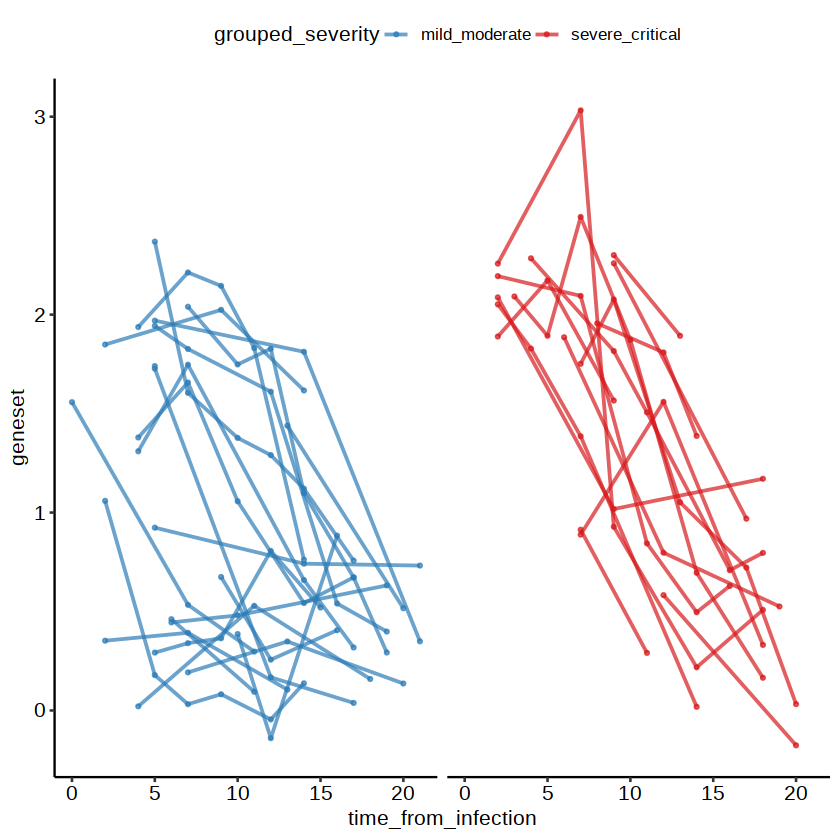

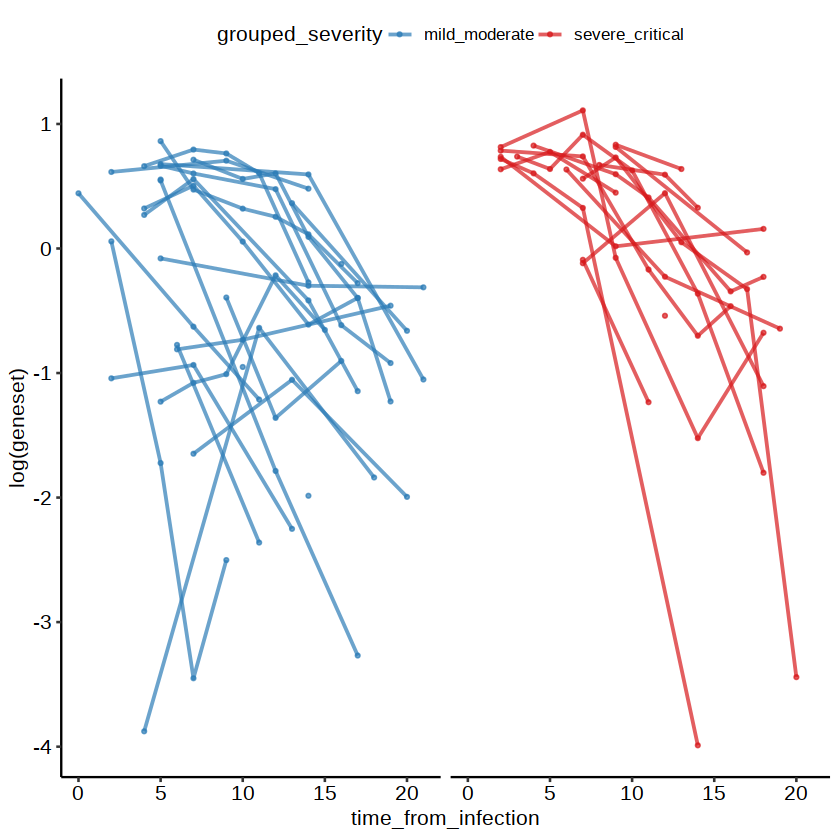

In [28]:
i = 26
x = emmeans(fits[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

pdf("/home/jovyan/scripts/renal_covid_19/from_kelvin/for_B_code_check/longitudinal_output_combined/INTERFERON_ALPHA_RESPONSE_monocyte.pdf")
print(ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) + ggtitle("INTERFERON_ALPHA_RESPONSE_monocyte") +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C")))
dev.off()

ggplot(fits[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())


png 
  2

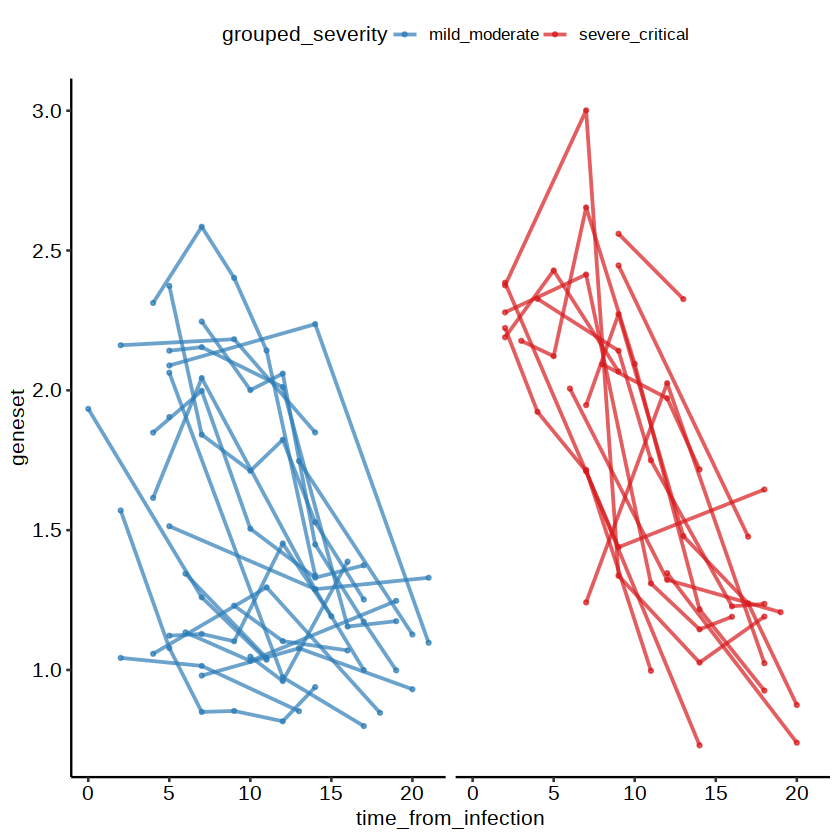

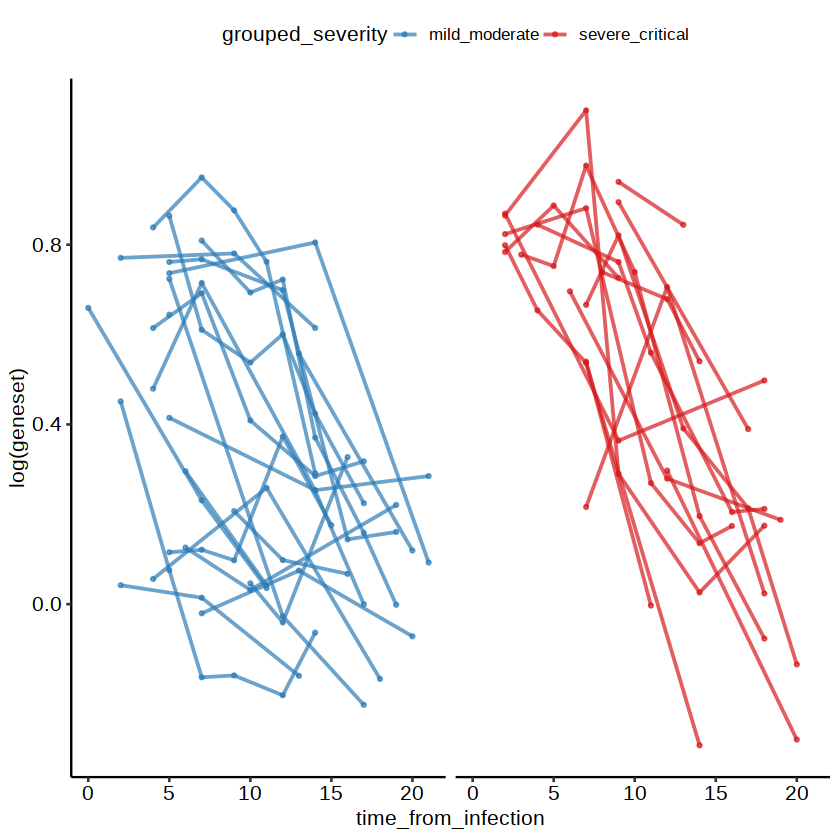

In [29]:
i = 27
x = emmeans(fits[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

pdf("/home/jovyan/scripts/renal_covid_19/from_kelvin/for_B_code_check/longitudinal_output_combined/INTERFERON_GAMMA_RESPONSE_monocyte.pdf")
print(ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) + ggtitle("INTERFERON_GAMMA_RESPONSE_monocyte") +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C")))
dev.off()

ggplot(fits[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

# Hallmark

In [ ]:
fullFormula = as.formula("geneset ~ splines::bs(time_from_infection, degree = 2) * grouped_severity + sex + PC1_nonafricanVsAfrican + PC2_asianVsEuropean + age_scaled + (1|individual_id)")
fullFormula

In [ ]:
m <- msigdbr(category = 'H')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)

In [ ]:
seu1 <- as.Seurat(wave1)
data1 <- seu1@meta.data
seu1 <- AddModuleScore(seu1, features = genelists, name = names(genelists))

In [ ]:
seu2 <- as.Seurat(wave2)
data2 <- seu2@meta.data
seu2 <- AddModuleScore(seu2, features = genelists, name = names(genelists))

In [ ]:
fits1 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data1$geneset <- seu1@meta.data[,x]
    fit <- suppressMessages(lmerTest::lmer(fullFormula, data = data1))
    return(list(fit=fit, data=data1))
})

In [ ]:
fits2 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data2$geneset <- seu2@meta.data[,x]
    fit <- suppressMessages(lmerTest::lmer(fullFormula, data = data2))
    return(list(fit=fit, data=data2))
})

In [ ]:
fit_res1[[1]]

In [ ]:
fit_res1 <- lapply(fits1, function(x) anova(x$fit))
singular1 <- lapply(fits1, function(x) as.numeric(isSingular(x$fit)))
conv1 <- lapply(fits1, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals1 <- lapply(fit_res1, function(x) x[7,6])
qvals1 <- p.adjust(pvals1, method = 'BH')
df1 = data.frame(pvals = unlist(pvals1), 
                qvals = unlist(qvals1), 
                singular = unlist(singular1), 
                conv = unlist(conv1), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df_unfiltered1 = df1
df1 = df1[df1$pvals < 0.05 & df1$conv == 0,]
df1

In [ ]:
fit_res2 <- lapply(fits2, function(x) anova(x$fit))
singular2 <- lapply(fits2, function(x) as.numeric(isSingular(x$fit)))
conv2 <- lapply(fits2, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals2 <- lapply(fit_res2, function(x) x[7,6])
qvals2 <- p.adjust(pvals2, method = 'BH')
df2 = data.frame(pvals = unlist(pvals2), 
                qvals = unlist(qvals2), 
                singular = unlist(singular2), 
                conv = unlist(conv2), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df_unfiltered2 = df2
df2 = df2[df2$pvals < 0.05 & df2$conv == 0,]
df2

In [ ]:
#df_unfiltered1

In [ ]:
i = 35
x = emmeans(fits1[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

pdf("/home/jovyan/scripts/renal_covid_19/from_kelvin/for_B_code_check/longitudinal_output/NOTCH_SIGNALIN_wave1_monocyte.pdf")
print(ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) + ggtitle("NOTCH_SIGNALIN_wave1_monocyte") +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C")))
dev.off()

ggplot(fits1[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits1[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())



In [ ]:
i = 37
x = emmeans(fits1[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

pdf("/home/jovyan/scripts/renal_covid_19/from_kelvin/for_B_code_check/longitudinal_output/P53_PATHWAY_wave1_monocyte.pdf")
a<-ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +ggtitle("P53_PATHWAY_wave1_monocyte") +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))
print(a)
dev.off()

ggplot(fits1[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits1[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

In [ ]:
i = 26
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

pdf("/home/jovyan/scripts/renal_covid_19/from_kelvin/for_B_code_check/longitudinal_output/INTERFERON_ALPHA_RESPONSE_wave2_monocyte.pdf")
ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +ggtitle('INTERFERON_ALPHA_RESPONSE_wave2_monocyte')+
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))
dev.off()

ggplot(fits2[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

In [ ]:
i = 27
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

pdf("/home/jovyan/scripts/renal_covid_19/from_kelvin/for_B_code_check/longitudinal_output/INTERFERON_GAMMA_RESPONSE_wave2_monocyte.pdf")
ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +ggtitle('INTERFERON_GAMMA_RESPONSE_wave2_monocyte')+
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))
dev.off()

ggplot(fits2[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

In [ ]:
i = 31
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())
pdf("/home/jovyan/scripts/renal_covid_19/from_kelvin/for_B_code_check/longitudinal_output/MTORC1_SIGNALING_wave2_monocyte.pdf")

ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +ggtitle('MTORC1_SIGNALING_wave2_monocyte')+
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))
dev.off()

ggplot(fits2[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

In [ ]:
i = 36
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

ggplot(fits2[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

# KEGG

In [ ]:
m <- msigdbr(category = 'C2', subcategory = 'CP:KEGG')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)

In [ ]:
seu1 <- as.Seurat(wave1)
data1 <- seu1@meta.data
seu1 <- AddModuleScore(seu1, features = genelists, name = names(genelists))

In [ ]:
seu2 <- as.Seurat(wave2)
data2 <- seu2@meta.data
seu2 <- AddModuleScore(seu2, features = genelists, name = names(genelists))

In [ ]:
fits1 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data1$geneset <- seu1@meta.data[,x]
    fit <- suppressMessages(lmerTest::lmer(fullFormula, data = data1))
    return(list(fit=fit, data=data1))
})

In [ ]:
fits2 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data2$geneset <- seu2@meta.data[,x]
    fit <- suppressMessages(lmerTest::lmer(fullFormula, data = data2))
    return(list(fit=fit, data=data2))
})

In [ ]:
fit_res1 <- lapply(fits1, function(x) anova(x$fit))
singular1 <- lapply(fits1, function(x) as.numeric(isSingular(x$fit)))
conv1 <- lapply(fits1, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals1 <- lapply(fit_res1, function(x) x[7,6])
qvals1 <- p.adjust(pvals1, method = 'BH')
df1 = data.frame(pvals = unlist(pvals1), 
                qvals = unlist(qvals1), 
                singular = unlist(singular1), 
                conv = unlist(conv1), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df_unfiltered1 = df1
df1 = df1[df1$pvals < 0.05 & df1$conv == 0,]
df1

In [ ]:
fit_res2 <- lapply(fits2, function(x) anova(x$fit))
singular2 <- lapply(fits2, function(x) as.numeric(isSingular(x$fit)))
conv2 <- lapply(fits2, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals2 <- lapply(fit_res2, function(x) x[7,6])
qvals2 <- p.adjust(pvals2, method = 'BH')
df2 = data.frame(pvals = unlist(pvals2), 
                qvals = unlist(qvals2), 
                singular = unlist(singular2), 
                conv = unlist(conv2), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df_unfiltered2 = df2
df2 = df2[df2$pvals < 0.05 & df2$conv == 0,]
df2

In [ ]:
i = 13
x = emmeans(fits1[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

pdf('/home/jovyan/scripts/renal_covid_19/from_kelvin/for_B_code_check/longitudinal_output/ANTIGEN_PROCESSING_AND_PRESENTATION_wave1_monocyte.pdf')
ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +ggtitle('ANTIGEN_PROCESSING_AND_PRESENTATION_wave1_monocyte')+
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))
dev.off()

ggplot(fits1[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits1[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

In [ ]:
i = 39
x = emmeans(fits1[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

pdf('/home/jovyan/scripts/renal_covid_19/from_kelvin/for_B_code_check/longitudinal_output/COMPLEMENT_AND_COAGULATION_CASCADES_wave1_monocyte.pdf')
ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +ggtitle('COMPLEMENT_AND_COAGULATION_CASCADES_wave1_monocyte')+
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))
dev.off()
ggplot(fits1[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits1[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

In [ ]:
i = 13
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

pdf('/home/jovyan/scripts/renal_covid_19/from_kelvin/for_B_code_check/longitudinal_output/ANTIGEN_PROCESSING_AND_PRESENTATION_wave2_monocyte.pdf')
ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +ggtitle('ANTIGEN_PROCESSING_AND_PRESENTATION_wave2_monocyte.pdf')+
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))
dev.off()

ggplot(fits2[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

# GO

In [ ]:
m <- msigdbr(category = 'C5', species = 'Homo sapiens', subcategory = 'BP')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)

In [ ]:
seu1 <- as.Seurat(wave1)
data1 <- seu1@meta.data
seu1 <- AddModuleScore(seu1, features = genelists, name = names(genelists))

In [ ]:
seu2 <- as.Seurat(wave2)
data2 <- seu2@meta.data
seu2 <- AddModuleScore(seu2, features = genelists, name = names(genelists))

In [ ]:
fits1 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data1$geneset <- seu1@meta.data[,x]
    fit <- suppressMessages(lmerTest::lmer(fullFormula, data = data1))
    return(list(fit=fit, data=data1))
})

In [ ]:
fits2 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data2$geneset <- seu2@meta.data[,x]
    fit <- suppressMessages(lmerTest::lmer(fullFormula, data = data2))
    return(list(fit=fit, data=data2))
})

In [ ]:
fit_res1 <- lapply(fits1, function(x) anova(x$fit))
singular1 <- lapply(fits1, function(x) as.numeric(isSingular(x$fit)))
conv1 <- lapply(fits1, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals1 <- lapply(fit_res1, function(x) x[6,6])
qvals1 <- p.adjust(pvals1, method = 'BH')
df1 = data.frame(pvals = unlist(pvals1), 
                qvals = unlist(qvals1), 
                singular = unlist(singular1), 
                conv = unlist(conv1), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df1 = df1[df1$pvals < 0.05 & df1$conv == 0,]
df1

In [ ]:
fit_res2 <- lapply(fits2, function(x) anova(x$fit))
singular2 <- lapply(fits2, function(x) as.numeric(isSingular(x$fit)))
conv2 <- lapply(fits2, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals2 <- lapply(fit_res2, function(x) x[6,6])
qvals2 <- p.adjust(pvals2, method = 'BH')
df2 = data.frame(pvals = unlist(pvals2), 
                qvals = unlist(qvals2), 
                singular = unlist(singular2), 
                conv = unlist(conv2), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df2 = df2[df2$pvals < 0.05 & df2$conv == 0,]
df2

In [ ]:
i = 13
x = emmeans(fits1[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

ggplot(fits1[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits1[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

In [ ]:
i = 13
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +ggtitle('ANTIGEN_PROCESSING_AND_PRESENTATION')
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

ggplot(fits2[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

# add vaccination as an interaction but for wave2 only

In [ ]:
fullFormula = as.formula("geneset ~ splines::bs(time_from_infection, degree = 2) * steroid + sex + PC1_nonafricanVsAfrican + PC2_asianVsEuropean + age_scaled + (1|individual_id)")
fullFormula

In [ ]:
m <- msigdbr(category = 'H')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)
seu2 <- as.Seurat(wave2)
data2 <- seu2@meta.data
seu2 <- AddModuleScore(seu2, features = genelists, name = names(genelists))               
fits2 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data2$geneset <- seu2@meta.data[,x]
    fit <- suppressMessages(lmerTest::lmer(fullFormula, data = data2))
    return(list(fit=fit, data=data2))
})

In [ ]:
fit_res2 <- lapply(fits2, function(x) anova(x$fit))
singular2 <- lapply(fits2, function(x) as.numeric(isSingular(x$fit)))
conv2 <- lapply(fits2, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals2 <- lapply(fit_res2, function(x) x[6,6])
qvals2 <- p.adjust(pvals2, method = 'BH')
df2 = data.frame(pvals = unlist(pvals2), 
                qvals = unlist(qvals2), 
                singular = unlist(singular2), 
                conv = unlist(conv2), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df2 = df2[df2$pvals < 0.05 & df2$conv == 0,]
df2

In [ ]:
names(genelists)[26]

In [ ]:
i = 4
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | steroid, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = steroid, fill = steroid)) +
    geom_line(aes(colour = steroid), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

In [ ]:
ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = vaccine)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~vaccine + grouped_severity) # +
    # theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

In [ ]:
i = 27
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | vaccine, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = vaccine, fill = vaccine)) +
    geom_line(aes(colour = vaccine), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))


In [ ]:
ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = vaccine)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~vaccine) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

In [ ]:
ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = vaccine)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~vaccine + grouped_severity) # +
    # theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

# KEGG

In [ ]:
## kegg
m <- msigdbr(category = 'C2', subcategory = 'CP:KEGG')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)
seu2 <- as.Seurat(wave2)
data2 <- seu2@meta.data
seu2 <- AddModuleScore(seu2, features = genelists, name = names(genelists))               
fits2 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data2$geneset <- seu2@meta.data[,x]
    fit <- suppressMessages(lmerTest::lmer(fullFormula, data = data2))
    return(list(fit=fit, data=data2))
})

In [ ]:
fit_res2 <- lapply(fits2, function(x) anova(x$fit))
singular2 <- lapply(fits2, function(x) as.numeric(isSingular(x$fit)))
conv2 <- lapply(fits2, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals2 <- lapply(fit_res2, function(x) x[6,6])
qvals2 <- p.adjust(pvals2, method = 'BH')
df2 = data.frame(pvals = unlist(pvals2), 
                qvals = unlist(qvals2), 
                singular = unlist(singular2), 
                conv = unlist(conv2), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df2 = df2[df2$pvals < 0.05 & df2$conv == 0,]
df2

In [ ]:
names(genelists)[13]

In [ ]:
names(genelists)[6]

In [ ]:
i = 13
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | vaccine, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = vaccine, fill = vaccine)) +
    geom_line(aes(colour = vaccine), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

# GO

In [ ]:
m <- msigdbr(category = 'C5', species = 'Homo sapiens', subcategory = 'BP')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)
seu2 <- as.Seurat(wave2)
data2 <- seu2@meta.data
seu2 <- AddModuleScore(seu2, features = genelists, name = names(genelists))               
fits2 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data2$geneset <- seu2@meta.data[,x]
    fit <- suppressMessages(lmerTest::lmer(fullFormula, data = data2))
    return(list(fit=fit, data=data2))
})

In [ ]:
genelists

In [ ]:
fit_res2 <- lapply(fits2, function(x) anova(x$fit))
singular2 <- lapply(fits2, function(x) as.numeric(isSingular(x$fit)))
conv2 <- lapply(fits2, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals2 <- lapply(fit_res2, function(x) x[6,6])
qvals2 <- p.adjust(pvals2, method = 'BH')
df2 = data.frame(pvals = unlist(pvals2), 
                qvals = unlist(qvals2), 
                singular = unlist(singular2), 
                conv = unlist(conv2), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df2 = df2[df2$pvals < 0.05 & df2$conv == 0,]
df2

# Repeat but only mild_moderate

In [ ]:
m <- msigdbr(category = 'H')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)
seu2 <- as.Seurat(wave2)
# subset to just mild_moderate
seu2 <- subset(seu2, subset = grouped_severity == 'mild_moderate')
data2 <- seu2@meta.data
seu2 <- AddModuleScore(seu2, features = genelists, name = names(genelists))               
fits2 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data2$geneset <- seu2@meta.data[,x]
    fit <- suppressMessages(lmerTest::lmer(fullFormula, data = data2))
    return(list(fit=fit, data=data2))
})

In [ ]:
fit_res2 <- lapply(fits2, function(x) anova(x$fit))
singular2 <- lapply(fits2, function(x) as.numeric(isSingular(x$fit)))
conv2 <- lapply(fits2, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals2 <- lapply(fit_res2, function(x) x[6,6])
qvals2 <- p.adjust(pvals2, method = 'BH')
df2 = data.frame(pvals = unlist(pvals2), 
                qvals = unlist(qvals2), 
                singular = unlist(singular2), 
                conv = unlist(conv2), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df2 = df2[df2$pvals < 0.05 & df2$conv == 0,]
df2

In [ ]:
i = 26
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | vaccine, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = vaccine, fill = vaccine)) +
    geom_line(aes(colour = vaccine), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

In [ ]:
ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = vaccine)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~vaccine + grouped_severity) # +
    # theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())